Import

In [ ]:
# Python set up
import warnings
import itertools
from pandas import read_csv
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot') 
import seaborn as sns  
sns.set(style="whitegrid")

# Kham pha du lieu

In [2]:
df = pd.read_csv("../data/data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

# Assign a frequency to the index
df = df.asfreq('D')  # Example: 'D' for daily frequency
# Adjust Frequency Based on Your Data
#     'D': Daily frequency.
#     'M': Monthly frequency.
#     'W': Weekly frequency.
#     'B': Business day frequency.
# # Fill missing dates with forward-fill
# df = df.asfreq('D').fillna(method='ffill')

# Chỉ quan tâm đến cột Adj Close
# data = df['Adj Close']

df.head()

,Adj Close
Date,
1960-01-04,4.52
1960-01-05,4.55
1960-01-06,4.68
1960-01-07,4.63
1960-01-08,4.59


## Kiểm tra độ chính xác và tính đầy đủ của dữ liệu

Trước khi tiếp tục, chúng ta sẽ kiểm tra dữ liệu có bị thiếu hay không và xác định các khoảng trống.

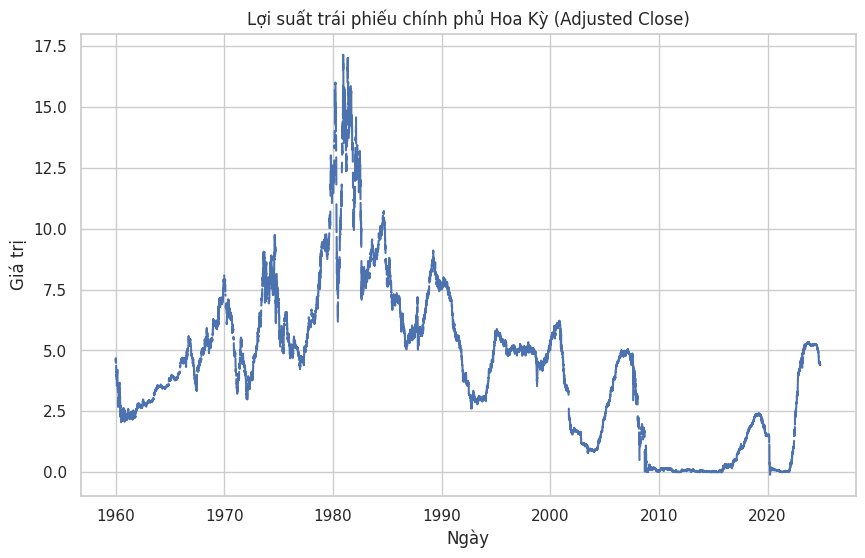

Dữ liệu thiếu trong mỗi cột:
 Adj Close    7457
dtype: int64


In [3]:
# Kiểm tra số lượng giá trị thiếu trong mỗi cột
missing_data = df.isnull().sum()

# Vẽ biểu đồ chuỗi thời gian để kiểm tra dữ liệu thiếu
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close')
plt.title('Lợi suất trái phiếu chính phủ Hoa Kỳ (Adjusted Close)')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.show()

# In ra số liệu thiếu
print("Dữ liệu thiếu trong mỗi cột:\n", missing_data)


## Xử lý dữ liệu thiếu

Nếu phát hiện dữ liệu thiếu, chúng ta sẽ sử dụng phương pháp nội suy để điền các giá trị thiếu.

In [4]:
# Nếu có dữ liệu thiếu, sử dụng phương pháp nội suy tuyến tính để điền giá trị thiếu
df['Adj Close'] = df['Adj Close'].interpolate(method='linear')

# Kiểm tra lại dữ liệu thiếu
missing_data_after_interpolation = df.isnull().sum()
print("Dữ liệu thiếu sau khi nội suy:\n", missing_data_after_interpolation)


Dữ liệu thiếu sau khi nội suy:
 Adj Close    0
dtype: int64


## Xử lý ngoại lai (Outliers)

Tiếp theo, chúng ta sẽ kiểm tra và loại bỏ các ngoại lai trong dữ liệu. Một trong những cách đơn giản để phát hiện ngoại lai là sử dụng phương pháp Z-score.

In [5]:
from scipy.stats import zscore

# Tính toán Z-score cho cột 'Adj Close'
z_scores = zscore(df['Adj Close'])
threshold = 3  # Xác định ngưỡng ngoại lai (giới hạn 3 là phổ biến)

# Tìm các chỉ số ngoại lai
outliers = df[abs(z_scores) > threshold]

# Loại bỏ các ngoại lai
df_cleaned = df[abs(z_scores) <= threshold]

print(f"Số lượng ngoại lai trước khi loại bỏ: {len(outliers)}")
print(f"Số lượng dữ liệu sau khi loại bỏ ngoại lai: {len(df_cleaned)}")

Số lượng ngoại lai trước khi loại bỏ: 337
Số lượng dữ liệu sau khi loại bỏ ngoại lai: 23349


## Chuẩn hóa và chuyển đổi dữ liệu

Để dữ liệu có thể dễ dàng xử lý trong các mô hình học máy, chúng ta sẽ chuẩn hóa các cột dữ liệu cần thiết, chẳng hạn như Adj Close.

In [6]:
from sklearn.preprocessing import StandardScaler

# Khởi tạo StandardScaler
scaler = StandardScaler()

# Chuẩn hóa dữ liệu cột 'Adj Close'
df_cleaned['Adj Close'] = scaler.fit_transform(df_cleaned[['Adj Close']])

# Kiểm tra lại dữ liệu sau khi chuẩn hóa
df_cleaned.head()

/tmp/ipykernel_660986/3045574855.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Adj Close'] = scaler.fit_transform(df_cleaned[['Adj Close']])


,Adj Close
Date,
1960-01-04,0.104434
1960-01-05,0.114767
1960-01-06,0.159544
1960-01-07,0.142322
1960-01-08,0.128545


## Phân chia dữ liệu

Sau khi làm sạch và chuẩn hóa dữ liệu, chúng ta sẽ chia dữ liệu thành các tập huấn luyện, kiểm tra và validation.

In [14]:
# Gán tần suất cho chỉ mục ngày tháng
df_cleaned = df_cleaned.asfreq('D')  # Tần suất hàng ngày

# Kiểm tra lại tần suất đã gán
print(df_cleaned.index.freq)

# Tính tỷ lệ phân chia: 60% huấn luyện, 20% kiểm tra, 20% validation
train_size = int(len(df_cleaned) * 0.6)
val_size = int(len(df_cleaned) * 0.2)

train_data = df_cleaned[:train_size]
val_data = df_cleaned[train_size:train_size + val_size]
test_data = df_cleaned[train_size + val_size:]

print(f"Số lượng mẫu huấn luyện: {len(train_data)}")
print(f"Số lượng mẫu validation: {len(val_data)}")
print(f"Số lượng mẫu kiểm tra: {len(test_data)}")


<Day>
Số lượng mẫu huấn luyện: 14211
Số lượng mẫu validation: 4737
Số lượng mẫu kiểm tra: 4738


---

# ARIMA

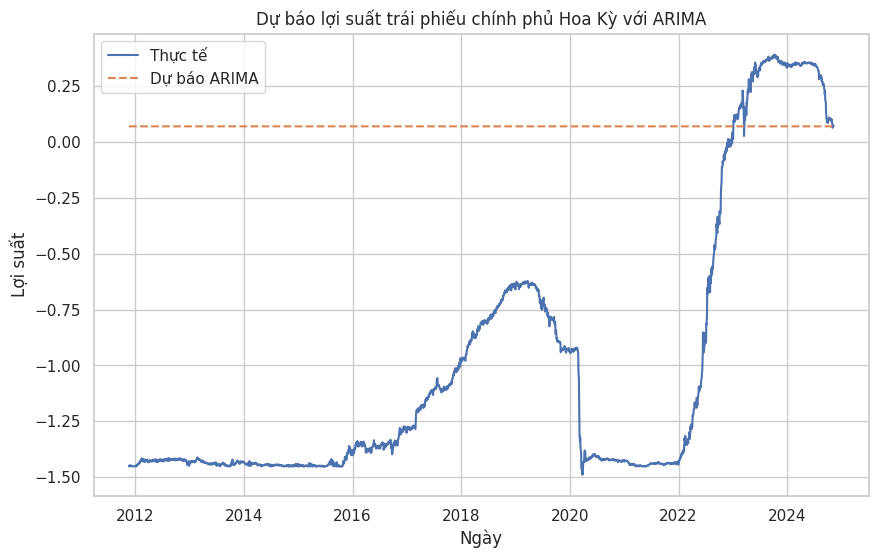

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Xây dựng mô hình ARIMA
model = ARIMA(train_data['Adj Close'], order=(2, 1, 2))  # (p, d, q) là các tham số ARIMA
model_fit = model.fit()

# Dự báo với mô hình ARIMA
forecast = model_fit.forecast(steps=len(test_data))

# Vẽ kết quả dự báo
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index[-len(test_data):], test_data['Adj Close'], label='Thực tế')
plt.plot(df_cleaned.index[-len(test_data):], forecast, label='Dự báo ARIMA', linestyle='--')
plt.title('Dự báo lợi suất trái phiếu chính phủ Hoa Kỳ với ARIMA')
plt.xlabel('Ngày')
plt.ylabel('Lợi suất')
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính toán MSE và MAE
mse = mean_squared_error(test_data['Adj Close'], forecast)
mae = mean_absolute_error(test_data['Adj Close'], forecast)

print(f'MSE: {mse}')
print(f'MAE: {mae}')


MSE: 1.510582766872424
MAE: 1.1303034187024505


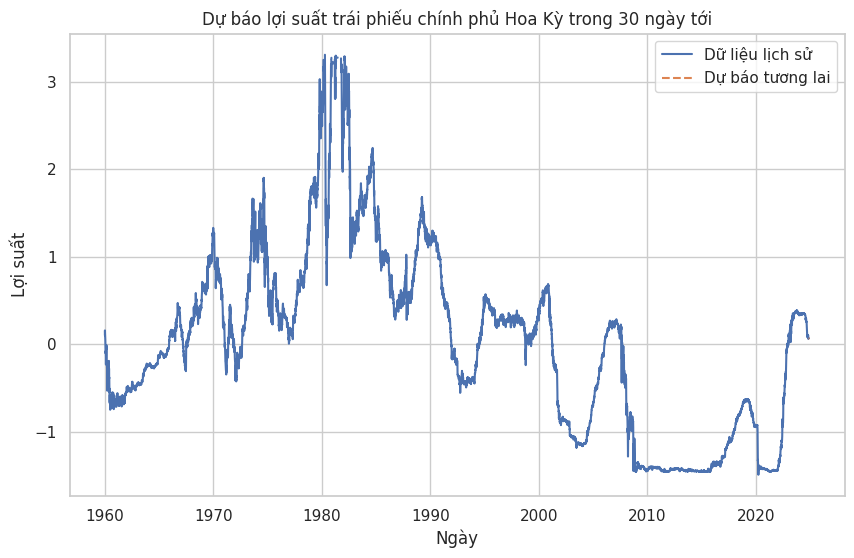

In [17]:
# Dự báo trong tương lai
future_steps = 30  # Dự báo 30 ngày tiếp theo
forecast_future = model_fit.forecast(steps=future_steps)

# Vẽ biểu đồ dự báo tương lai
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index, df_cleaned['Adj Close'], label='Dữ liệu lịch sử')
plt.plot(pd.date_range(df_cleaned.index[-1], periods=future_steps + 1, freq='D')[1:], forecast_future, label='Dự báo tương lai', linestyle='--')
plt.title('Dự báo lợi suất trái phiếu chính phủ Hoa Kỳ trong 30 ngày tới')
plt.xlabel('Ngày')
plt.ylabel('Lợi suất')
plt.legend()
plt.show()


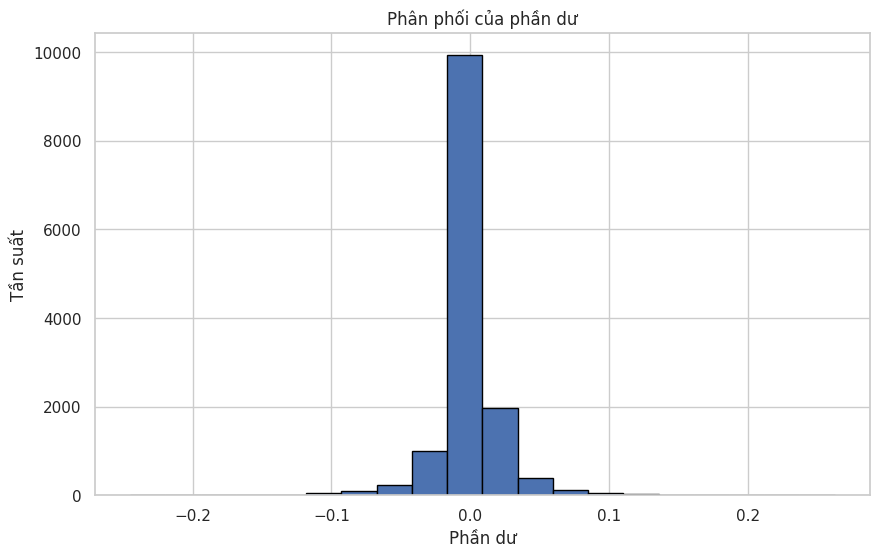

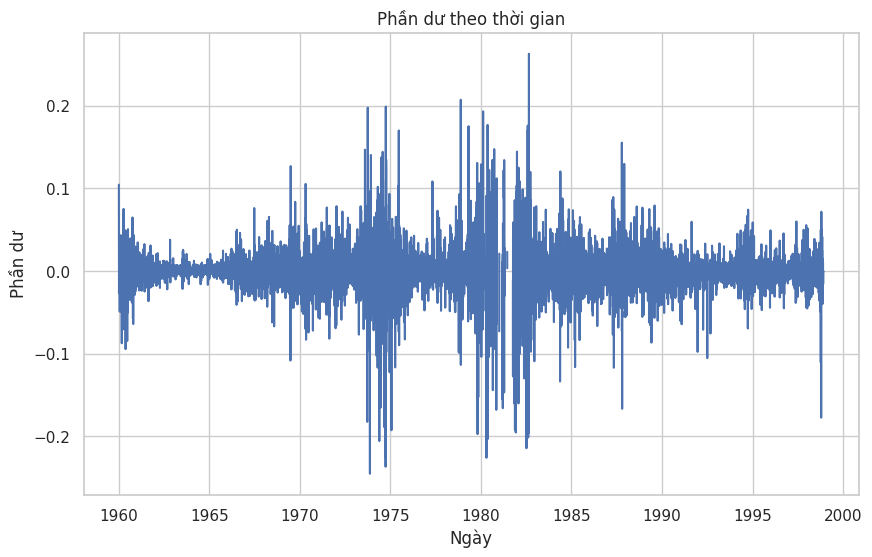

In [18]:
# Tính phần dư của mô hình
residuals = model_fit.resid

# Vẽ biểu đồ phân phối của phần dư
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Phân phối của phần dư')
plt.xlabel('Phần dư')
plt.ylabel('Tần suất')
plt.show()

# Vẽ biểu đồ phần dư theo thời gian
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Phần dư theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Phần dư')
plt.show()


In [22]:
from scipy.stats import shapiro

# Kiểm tra phân phối chuẩn của phần dư với kiểm định Shapiro-Wilk
stat, p_value = shapiro(residuals.dropna())
print(f'Giá trị thống kê Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("Phần dư có phân phối chuẩn (không bác bỏ H0)")
else:
    print("Phần dư không có phân phối chuẩn (bác bỏ H0)")


Giá trị thống kê Shapiro-Wilk: 0.7482643259632531
P-value: 2.0208517437336458e-89
Phần dư không có phân phối chuẩn (bác bỏ H0)


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13874.
  res = hypotest_fun_out(*samples, **kwds)


In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Kiểm định Ljung-Box để kiểm tra tự tương quan của phần dư
ljungbox_test = acorr_ljungbox(residuals.dropna(), lags=40)
print(ljungbox_test)


       lb_stat     lb_pvalue
1     0.070333  7.908527e-01
2     0.151373  9.271070e-01
3     0.214871  9.751537e-01
4     0.411823  9.814975e-01
5     4.127006  5.312790e-01
6     4.489076  6.107970e-01
7    83.717683  2.398322e-15
8    85.818168  3.273550e-15
9    86.346854  8.778765e-15
10   86.608462  2.512739e-14
11   87.212026  5.852545e-14
12   92.488200  1.625648e-14
13   92.714125  4.219827e-14
14  175.431865  5.457382e-30
15  176.144994  1.421717e-29
16  182.534522  2.613037e-30
17  190.126358  2.740064e-31
18  191.385193  5.250664e-31
19  195.229602  3.018652e-31
20  195.883625  7.323886e-31
21  255.216721  3.674653e-42
22  270.026890  1.385352e-44
23  285.224244  4.369340e-47
24  287.423250  5.654648e-47
25  290.125102  5.719948e-47
26  292.407521  6.927688e-47
27  292.964642  1.824559e-46
28  383.077190  5.263151e-64
29  383.112818  1.937326e-63
30  383.751682  5.296273e-63
31  383.757503  1.910288e-62
32  383.846773  6.520611e-62
33  388.656931  2.496082e-62
34  393.516653

In [27]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant

# Thực hiện kiểm định Breusch-Pagan
X = add_constant(train_data['Adj Close'].dropna())
bp_test = het_breuschpagan(residuals.dropna(), X)
print(f'Giá trị thống kê Breusch-Pagan: {bp_test[0]}')
print(f'P-value: {bp_test[1]}')

if bp_test[1] > 0.05:
    print("Không phát hiện heteroscedasticity (phương sai ổn định)")
else:
    print("Phát hiện heteroscedasticity (phương sai không ổn định)")


Giá trị thống kê Breusch-Pagan: 660.897013628976
P-value: 9.533567429604518e-146
Phát hiện heteroscedasticity (phương sai không ổn định)


In [28]:
# Tính AIC và BIC
print(f'AIC: {model_fit.aic}')
print(f'BIC: {model_fit.bic}')

# Tính RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_data['Adj Close'], forecast))
print(f'RMSE: {rmse}')


AIC: -65698.53493295544
BIC: -65660.72642684999
RMSE: 1.229057674347475


---

SARIMA

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Xây dựng mô hình SARIMA (p,d,q)(P,D,Q,s) với các tham số đã cho
model_sarima = SARIMAX(
    train_data["Adj Close"],
    order=(2, 1, 2),  # (p,d,q)
    seasonal_order=(2, 1, 2, 7),  # (P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# Huấn luyện mô hình
model_sarima_fit = model_sarima.fit()

# Dự báo với mô hình SARIMA
forecast_sarima = model_sarima_fit.forecast(steps=len(test_data))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17825D+00    |proj g|=  1.30961D+01


 This problem is unconstrained.



At iterate    5    f= -2.24436D+00    |proj g|=  3.79654D+00

At iterate   10    f= -2.28441D+00    |proj g|=  1.47754D-01

At iterate   15    f= -2.29023D+00    |proj g|=  5.39580D+00

At iterate   20    f= -2.29579D+00    |proj g|=  5.33635D-01

At iterate   25    f= -2.30697D+00    |proj g|=  2.81803D+00

At iterate   30    f= -2.31596D+00    |proj g|=  2.95711D-01

At iterate   35    f= -2.31701D+00    |proj g|=  2.38291D+00

At iterate   40    f= -2.31981D+00    |proj g|=  2.01397D-01

At iterate   45    f= -2.31990D+00    |proj g|=  4.99689D-02


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -2.32005D+00    |proj g|=  1.17229D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68      1     0     0   1.172D+00  -2.320D+00
  F =  -2.3200477593713589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


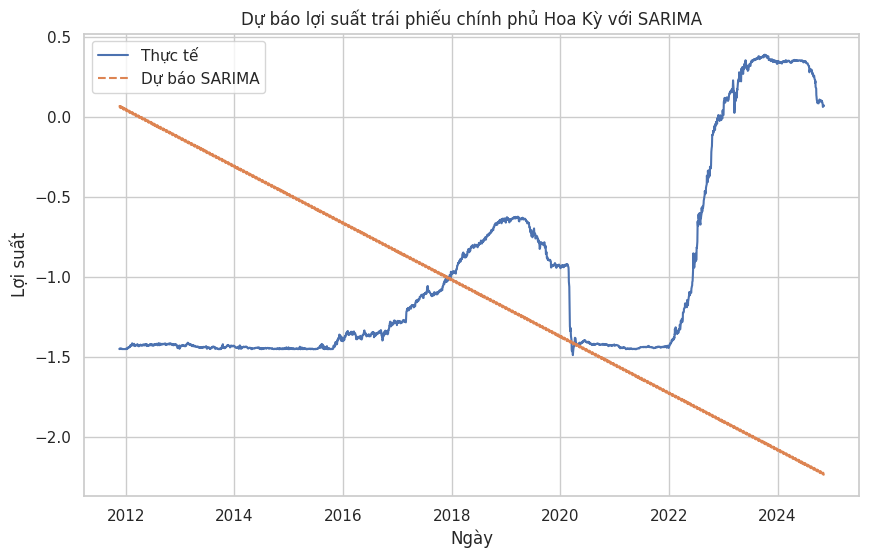

In [30]:
# Vẽ kết quả dự báo
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index[-len(test_data):], test_data['Adj Close'], label='Thực tế')
plt.plot(df_cleaned.index[-len(test_data):], forecast_sarima, label='Dự báo SARIMA', linestyle='--')
plt.title('Dự báo lợi suất trái phiếu chính phủ Hoa Kỳ với SARIMA')
plt.xlabel('Ngày')
plt.ylabel('Lợi suất')
plt.legend()
plt.show()


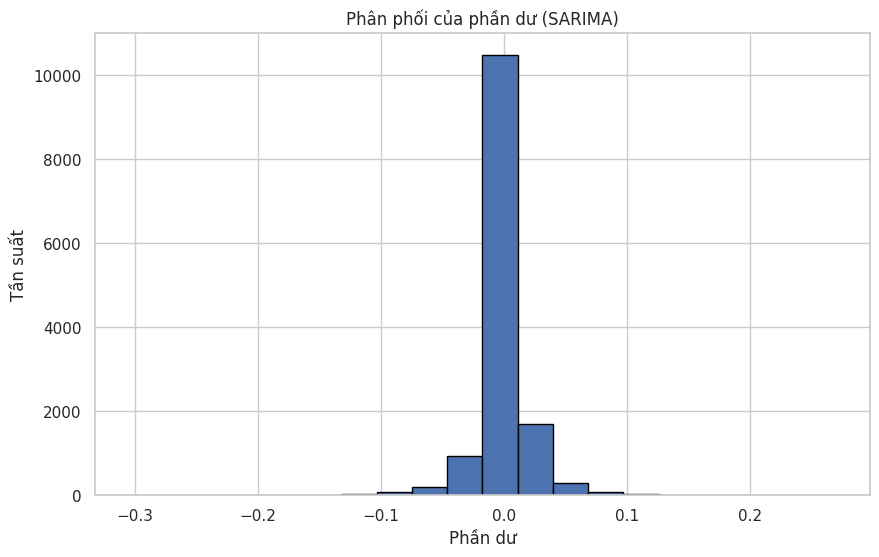

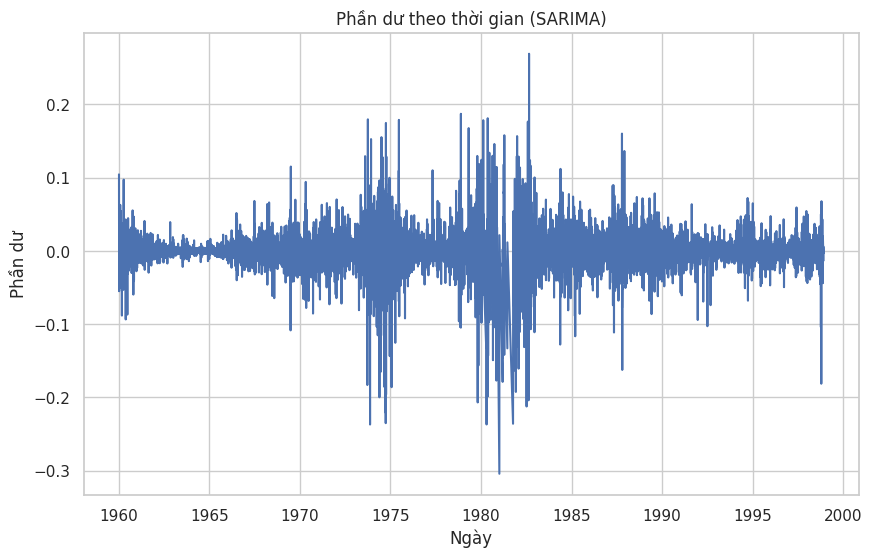

In [31]:
# Tính phần dư của mô hình SARIMA
residuals_sarima = model_sarima_fit.resid.dropna()

# Vẽ biểu đồ phân phối của phần dư
plt.figure(figsize=(10, 6))
plt.hist(residuals_sarima, bins=20, edgecolor='black')
plt.title('Phân phối của phần dư (SARIMA)')
plt.xlabel('Phần dư')
plt.ylabel('Tần suất')
plt.show()

# Vẽ biểu đồ phần dư theo thời gian
plt.figure(figsize=(10, 6))
plt.plot(residuals_sarima)
plt.title('Phần dư theo thời gian (SARIMA)')
plt.xlabel('Ngày')
plt.ylabel('Phần dư')
plt.show()


In [32]:
# Kiểm tra phân phối chuẩn của phần dư với kiểm định Shapiro-Wilk
from scipy.stats import shapiro

stat, p_value = shapiro(residuals_sarima)
print(f'Giá trị thống kê Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("Phần dư có phân phối chuẩn (không bác bỏ H0)")
else:
    print("Phần dư không có phân phối chuẩn (bác bỏ H0)")


Giá trị thống kê Shapiro-Wilk: 0.7405015596344531
P-value: 3.886358157685403e-90
Phần dư không có phân phối chuẩn (bác bỏ H0)


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13874.
  res = hypotest_fun_out(*samples, **kwds)


In [33]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Kiểm định Ljung-Box để kiểm tra tự tương quan của phần dư
ljungbox_test_sarima = acorr_ljungbox(residuals_sarima, lags=40)
print(ljungbox_test_sarima)

       lb_stat     lb_pvalue
1     0.167174  6.826360e-01
2     4.745953  9.320288e-02
3     6.931918  7.409973e-02
4     6.955368  1.382657e-01
5     7.049546  2.169815e-01
6     7.074537  3.140091e-01
7     8.616404  2.813819e-01
8     9.156520  3.292648e-01
9    12.596142  1.817479e-01
10   13.295496  2.076164e-01
11   13.300362  2.741481e-01
12   14.500575  2.698902e-01
13   14.557579  3.357798e-01
14   21.276836  9.474579e-02
15   24.381445  5.889259e-02
16   27.475818  3.648795e-02
17   28.724340  3.715408e-02
18   30.136647  3.613898e-02
19   30.359803  4.739417e-02
20   31.164654  5.305394e-02
21   37.199876  1.596604e-02
22   54.001541  1.644063e-04
23   64.088748  9.592988e-06
24   66.817555  6.563076e-06
25   71.769382  2.094154e-06
26   71.771569  3.650948e-06
27   71.807074  6.172614e-06
28   90.142052  1.883789e-08
29   90.510164  3.037631e-08
30   90.794552  4.974165e-08
31   91.516559  6.902820e-08
32   92.970700  7.381076e-08
33   96.326091  4.100468e-08
34  105.221660

In [35]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant

# Thực hiện kiểm định Breusch-Pagan
X_sarima = add_constant(train_data['Adj Close'].dropna())
bp_test_sarima = het_breuschpagan(residuals_sarima, X_sarima)
print(f'Giá trị thống kê Breusch-Pagan: {bp_test_sarima[0]}')
print(f'P-value: {bp_test_sarima[1]}')

if bp_test_sarima[1] > 0.05:
    print("Không phát hiện heteroscedasticity (phương sai ổn định)")
else:
    print("Phát hiện heteroscedasticity (phương sai không ổn định)")


Giá trị thống kê Breusch-Pagan: 695.3454363012918
P-value: 3.0752074074755107e-153
Phát hiện heteroscedasticity (phương sai không ổn định)


In [36]:
# Tính AIC và BIC
print(f'AIC: {model_sarima_fit.aic}')
print(f'BIC: {model_sarima_fit.bic}')

# Tính RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sarima = np.sqrt(mean_squared_error(test_data['Adj Close'], forecast_sarima))
print(f'RMSE: {rmse_sarima}')


AIC: -65922.39741685276
BIC: -65854.35731927691
RMSE: 1.1829785335438798


---

ARCH

Iteration:      1,   Func. Count:      5,   Neg. LLF: 6.619627545256674e+18
Iteration:      2,   Func. Count:     18,   Neg. LLF: 447889.4174977406
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7881.226105197063
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1049193.2535253293
Iteration:      5,   Func. Count:     41,   Neg. LLF: 14059.352654904116
Iteration:      6,   Func. Count:     47,   Neg. LLF: 5511.7381226744465
Iteration:      7,   Func. Count:     51,   Neg. LLF: 5399.909665631369
Iteration:      8,   Func. Count:     55,   Neg. LLF: 5985.043024030629
Iteration:      9,   Func. Count:     61,   Neg. LLF: 5398.5174566183505
Iteration:     10,   Func. Count:     65,   Neg. LLF: 5393.449417974563
Iteration:     11,   Func. Count:     69,   Neg. LLF: 5375.899864988362
Iteration:     12,   Func. Count:     73,   Neg. LLF: 5358.091775465185
Iteration:     13,   Func. Count:     77,   Neg. LLF: 5351.250662763118
Iteration:     14,   Func. Count:     81,   Neg. LLF: 53

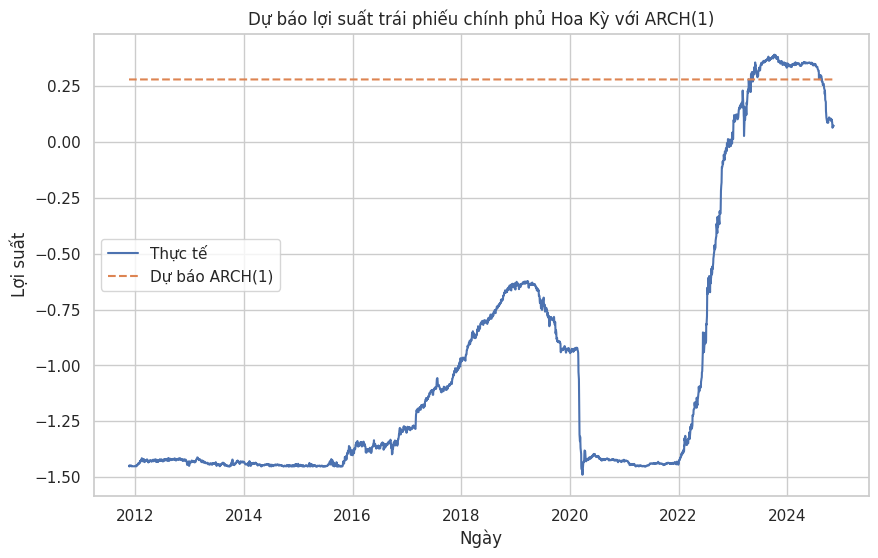

In [38]:
from arch import arch_model
import matplotlib.pyplot as plt

# Xây dựng mô hình ARCH(1)
model_arch = arch_model(train_data['Adj Close'].dropna(), vol='ARCH', p=1)

# Huấn luyện mô hình
model_arch_fit = model_arch.fit()

# Dự báo với mô hình ARCH(1)
forecast_arch = model_arch_fit.forecast(horizon=len(test_data))

# Dự báo biến động (conditional volatility) trong mô hình ARCH
volatility_forecast = forecast_arch.variance.values[-1, :]

# Vẽ kết quả dự báo
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index[-len(test_data):], test_data['Adj Close'], label='Thực tế')
plt.plot(df_cleaned.index[-len(test_data):], forecast_arch.mean.values[-1, :], label='Dự báo ARCH(1)', linestyle='--')
plt.title('Dự báo lợi suất trái phiếu chính phủ Hoa Kỳ với ARCH(1)')
plt.xlabel('Ngày')
plt.ylabel('Lợi suất')
plt.legend()
plt.show()

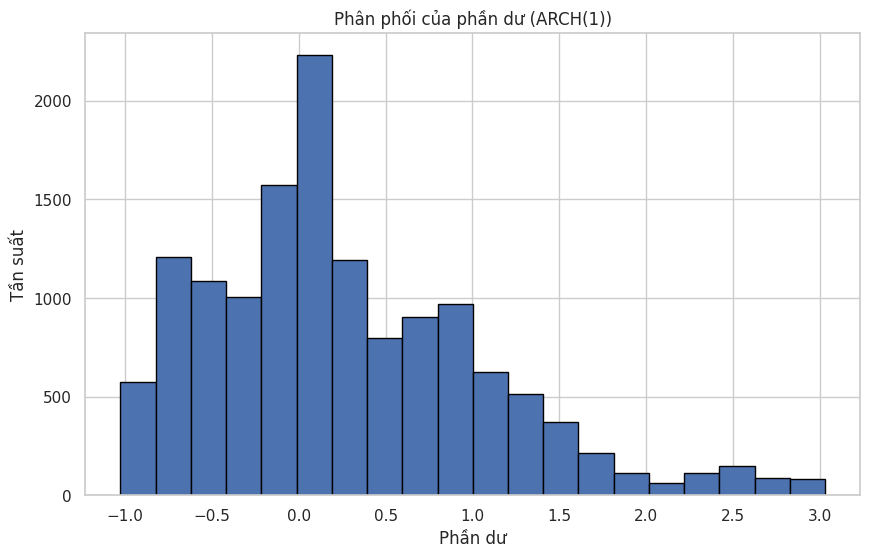

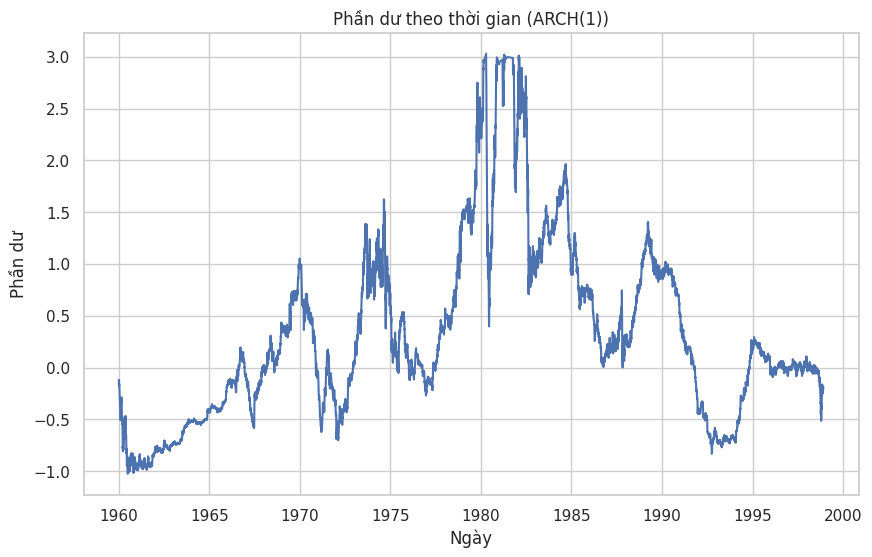

In [39]:
# Tính phần dư của mô hình ARCH(1)
residuals_arch = model_arch_fit.resid.dropna()

# Vẽ biểu đồ phân phối của phần dư
plt.figure(figsize=(10, 6))
plt.hist(residuals_arch, bins=20, edgecolor='black')
plt.title('Phân phối của phần dư (ARCH(1))')
plt.xlabel('Phần dư')
plt.ylabel('Tần suất')
plt.show()

# Vẽ biểu đồ phần dư theo thời gian
plt.figure(figsize=(10, 6))
plt.plot(residuals_arch)
plt.title('Phần dư theo thời gian (ARCH(1))')
plt.xlabel('Ngày')
plt.ylabel('Phần dư')
plt.show()


In [40]:
# Kiểm tra phân phối chuẩn của phần dư với kiểm định Shapiro-Wilk
from scipy.stats import shapiro

stat, p_value = shapiro(residuals_arch)
print(f'Giá trị thống kê Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("Phần dư có phân phối chuẩn (không bác bỏ H0)")
else:
    print("Phần dư không có phân phối chuẩn (bác bỏ H0)")


Giá trị thống kê Shapiro-Wilk: 0.9478961079414716
P-value: 2.8041807753588353e-56
Phần dư không có phân phối chuẩn (bác bỏ H0)


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13874.
  res = hypotest_fun_out(*samples, **kwds)


In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Kiểm định Ljung-Box để kiểm tra tự tương quan của phần dư
ljungbox_test_arch = acorr_ljungbox(residuals_arch, lags=40)
print(ljungbox_test_arch)


          lb_stat  lb_pvalue
1    13864.548710        0.0
2    27712.695580        0.0
3    41542.429420        0.0
4    55352.786647        0.0
5    69143.427071        0.0
6    82914.426578        0.0
7    96665.543423        0.0
8   110395.064533        0.0
9   124102.862936        0.0
10  137788.701866        0.0
11  151452.408191        0.0
12  165094.091565        0.0
13  178714.078772        0.0
14  192312.180286        0.0
15  205886.717047        0.0
16  219437.273856        0.0
17  232964.259326        0.0
18  246468.208061        0.0
19  259949.028440        0.0
20  273407.085337        0.0
21  286842.433317        0.0
22  300253.896407        0.0
23  313642.079653        0.0
24  327007.814994        0.0
25  340351.480280        0.0
26  353672.873259        0.0
27  366972.166598        0.0
28  380249.160098        0.0
29  393502.041870        0.0
30  406730.491252        0.0
31  419934.537325        0.0
32  433114.119964        0.0
33  446269.117575        0.0
34  459399.699

In [43]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant

# Thực hiện kiểm định Breusch-Pagan
X_arch = add_constant(train_data['Adj Close'].dropna())
bp_test_arch = het_breuschpagan(residuals_arch, X_arch)
print(f'Giá trị thống kê Breusch-Pagan: {bp_test_arch[0]}')
print(f'P-value: {bp_test_arch[1]}')

if bp_test_arch[1] > 0.05:
    print("Không phát hiện heteroscedasticity (phương sai ổn định)")
else:
    print("Phát hiện heteroscedasticity (phương sai không ổn định)")


Giá trị thống kê Breusch-Pagan: 7617.82906848946
P-value: 0.0
Phát hiện heteroscedasticity (phương sai không ổn định)


In [44]:
# Tính AIC và BIC của mô hình ARCH(1)
print(f'AIC: {model_arch_fit.aic}')
print(f'BIC: {model_arch_fit.bic}')

# Tính RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_arch = np.sqrt(mean_squared_error(test_data['Adj Close'], forecast_arch.mean.values[-1, :]))
print(f'RMSE: {rmse_arch}')


AIC: 10704.663554100276
BIC: 10727.276869692112
RMSE: 1.4151347697785535


---

GARCH(1,1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 198854079.46927404
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2537522.081480551
Iteration:      3,   Func. Count:     31,   Neg. LLF: 26801806227.743103
Iteration:      4,   Func. Count:     37,   Neg. LLF: 48814.14736147135
Iteration:      5,   Func. Count:     45,   Neg. LLF: 12017.30446688292
Iteration:      6,   Func. Count:     52,   Neg. LLF: 2.013682193809762e+18
Iteration:      7,   Func. Count:     65,   Neg. LLF: 11476648745.148052
Iteration:      8,   Func. Count:     71,   Neg. LLF: 12566.658366095839
Iteration:      9,   Func. Count:     78,   Neg. LLF: 6097.687538233937
Iteration:     10,   Func. Count:     83,   Neg. LLF: 20391.303731465377
Iteration:     11,   Func. Count:     96,   Neg. LLF: 25240.410352497784
Iteration:     12,   Func. Count:    106,   Neg. LLF: 18235.601867224752
Iteration:     13,   Func. Count:    112,   Neg. LLF: 9511.543438242605
Iteration:     14,   Func. Count:    118,   Neg. LLF:

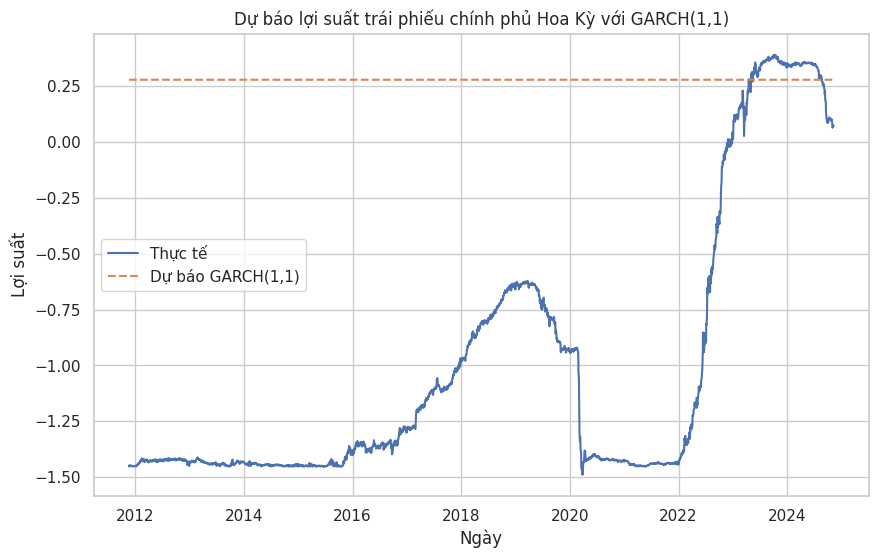

In [45]:
from arch import arch_model
import matplotlib.pyplot as plt

# Xây dựng mô hình GARCH(1,1)
model_garch = arch_model(train_data['Adj Close'].dropna(), vol='Garch', p=1, q=1)

# Huấn luyện mô hình
model_garch_fit = model_garch.fit()

# Dự báo với mô hình GARCH(1,1)
forecast_garch = model_garch_fit.forecast(horizon=len(test_data))

# Dự báo biến động (conditional volatility) trong mô hình GARCH
volatility_forecast = forecast_garch.variance.values[-1, :]

# Vẽ kết quả dự báo
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index[-len(test_data):], test_data['Adj Close'], label='Thực tế')
plt.plot(df_cleaned.index[-len(test_data):], forecast_garch.mean.values[-1, :], label='Dự báo GARCH(1,1)', linestyle='--')
plt.title('Dự báo lợi suất trái phiếu chính phủ Hoa Kỳ với GARCH(1,1)')
plt.xlabel('Ngày')
plt.ylabel('Lợi suất')
plt.legend()
plt.show()


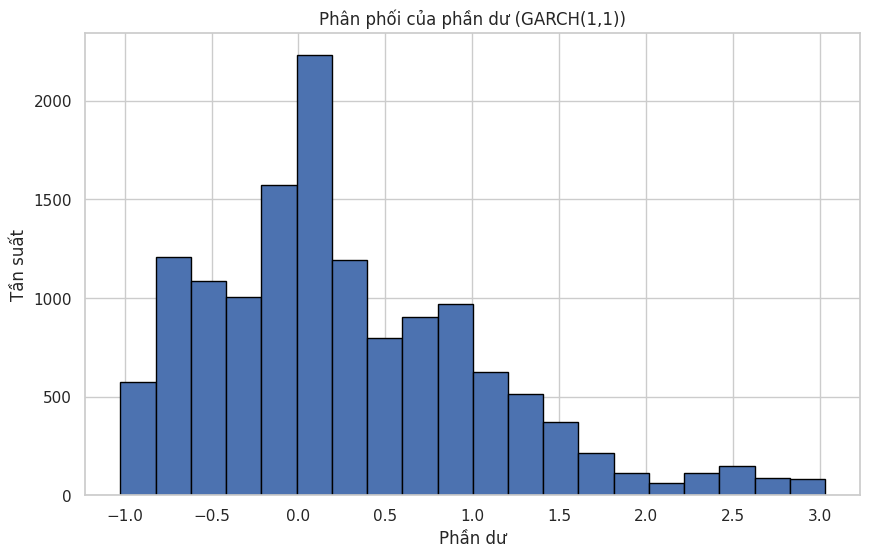

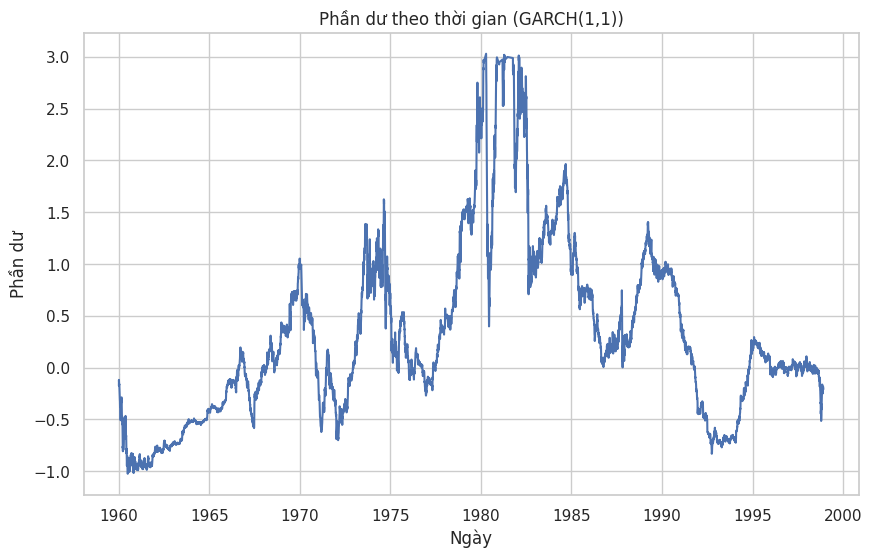

In [47]:
# Tính phần dư của mô hình GARCH(1,1)
residuals_garch = model_garch_fit.resid.dropna()

# Vẽ biểu đồ phân phối của phần dư
plt.figure(figsize=(10, 6))
plt.hist(residuals_garch, bins=20, edgecolor='black')
plt.title('Phân phối của phần dư (GARCH(1,1))')
plt.xlabel('Phần dư')
plt.ylabel('Tần suất')
plt.show()

# Vẽ biểu đồ phần dư theo thời gian
plt.figure(figsize=(10, 6))
plt.plot(residuals_garch)
plt.title('Phần dư theo thời gian (GARCH(1,1))')
plt.xlabel('Ngày')
plt.ylabel('Phần dư')
plt.show()


In [48]:
from scipy.stats import shapiro

# Kiểm tra phân phối chuẩn của phần dư với kiểm định Shapiro-Wilk
stat, p_value = shapiro(residuals_garch)
print(f'Giá trị thống kê Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("Phần dư có phân phối chuẩn (không bác bỏ H0)")
else:
    print("Phần dư không có phân phối chuẩn (bác bỏ H0)")


Giá trị thống kê Shapiro-Wilk: 0.9478961079414716
P-value: 2.8041807753588353e-56
Phần dư không có phân phối chuẩn (bác bỏ H0)


/Data/Projects/venv_manager/ai_work#311/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13874.
  res = hypotest_fun_out(*samples, **kwds)


In [49]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Kiểm định Ljung-Box để kiểm tra tự tương quan của phần dư
ljungbox_test_garch = acorr_ljungbox(residuals_garch, lags=40)
print(ljungbox_test_garch)


          lb_stat  lb_pvalue
1    13864.548710        0.0
2    27712.695580        0.0
3    41542.429420        0.0
4    55352.786647        0.0
5    69143.427071        0.0
6    82914.426578        0.0
7    96665.543423        0.0
8   110395.064533        0.0
9   124102.862936        0.0
10  137788.701866        0.0
11  151452.408191        0.0
12  165094.091565        0.0
13  178714.078772        0.0
14  192312.180286        0.0
15  205886.717047        0.0
16  219437.273856        0.0
17  232964.259326        0.0
18  246468.208061        0.0
19  259949.028440        0.0
20  273407.085337        0.0
21  286842.433317        0.0
22  300253.896407        0.0
23  313642.079653        0.0
24  327007.814994        0.0
25  340351.480280        0.0
26  353672.873259        0.0
27  366972.166598        0.0
28  380249.160098        0.0
29  393502.041870        0.0
30  406730.491252        0.0
31  419934.537325        0.0
32  433114.119964        0.0
33  446269.117575        0.0
34  459399.699

In [51]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant

# Thực hiện kiểm định Breusch-Pagan
X_garch = add_constant(train_data['Adj Close'].dropna())
bp_test_garch = het_breuschpagan(residuals_garch, X_garch)
print(f'Giá trị thống kê Breusch-Pagan: {bp_test_garch[0]}')
print(f'P-value: {bp_test_garch[1]}')

if bp_test_garch[1] > 0.05:
    print("Không phát hiện heteroscedasticity (phương sai ổn định)")
else:
    print("Phát hiện heteroscedasticity (phương sai không ổn định)")


Giá trị thống kê Breusch-Pagan: 7632.684569642471
P-value: 0.0
Phát hiện heteroscedasticity (phương sai không ổn định)


In [52]:
# Tính AIC và BIC của mô hình GARCH(1,1)
print(f'AIC: {model_garch_fit.aic}')
print(f'BIC: {model_garch_fit.bic}')

# Tính RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_garch = np.sqrt(mean_squared_error(test_data['Adj Close'], forecast_garch.mean.values[-1, :]))
print(f'RMSE: {rmse_garch}')


AIC: 10580.55261277468
BIC: 10610.70370023046
RMSE: 1.4139398595677315


---

LSTM

In [56]:
# Kiểm tra xem dữ liệu có chứa NaN hay không
print(df_cleaned.isnull().sum())

# Loại bỏ các dòng có NaN trong dữ liệu
df_cleaned = df_cleaned.dropna(subset=['Adj Close'])

# Hoặc thay thế NaN bằng giá trị trung bình (có thể thay thế bằng phương pháp khác nếu cần)
df_cleaned['Adj Close'].fillna(df_cleaned['Adj Close'].mean(), inplace=True)

# Kiểm tra lại sau khi xử lý
print(df_cleaned.isnull().sum())


Adj Close    337
dtype: int64
Adj Close    0
dtype: int64


/tmp/ipykernel_660986/2781410625.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Adj Close'].fillna(df_cleaned['Adj Close'].mean(), inplace=True)


In [57]:
# Tiền xử lý dữ liệu với MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_cleaned['Adj Close'].values.reshape(-1, 1))

# Tạo dữ liệu cho mô hình LSTM với time_step = 60
time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Định dạng lại dữ liệu thành (samples, time_step, features) cho LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Kiểm tra dữ liệu đầu vào
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')


X_train shape: (18630, 60, 1)
X_test shape: (4658, 60, 1)


In [59]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Lớp LSTM đầu tiên
model.add(LSTM(units=50, return_sequences=False))  # Lớp LSTM thứ hai
model.add(Dense(units=1))  # Lớp Dense cho dự báo giá trị tiếp theo

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình LSTM
history = model.fit(X_train, y_train, epochs=5, batch_size=120, validation_data=(X_test, y_test))


Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0134 - val_loss: 3.3092e-05
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 1.8933e-04 - val_loss: 2.8012e-05
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 1.7518e-04 - val_loss: 2.6760e-05
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 1.6627e-04 - val_loss: 2.2816e-05
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 1.5329e-04 - val_loss: 1.9429e-05


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Chuyển đổi dữ liệu chuỗi thời gian thành dạng phù hợp với LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Tiền xử lý dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_cleaned['Adj Close'].values.reshape(-1, 1))

# Tạo dữ liệu cho mô hình LSTM
time_step = 60  # Sử dụng 60 ngày trước đó để dự báo giá trị tiếp theo
X, y = create_dataset(scaled_data, time_step)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Định dạng lại dữ liệu thành dạng (samples, time_step, features) cho LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


2024-11-19 22:27:52.782524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 22:27:52.793295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732030072.802660  660986 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732030072.805103  660986 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 22:27:52.814176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


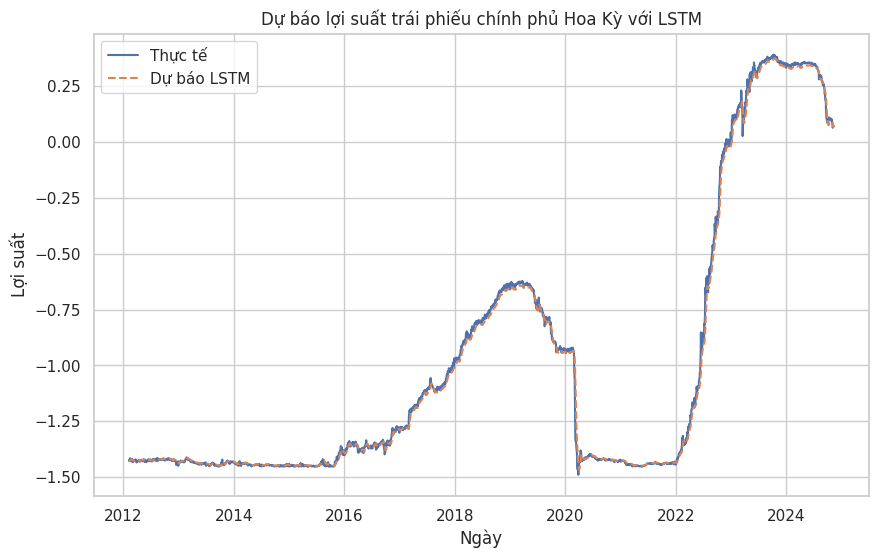

In [60]:
# Dự báo trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Chuyển đổi lại kết quả dự báo và thực tế về giá trị gốc (ngược lại với bước chuẩn hóa)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Vẽ kết quả dự báo
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index[-len(y_test):], y_test_rescaled, label='Thực tế')
plt.plot(df_cleaned.index[-len(y_test):], y_pred_rescaled, label='Dự báo LSTM', linestyle='--')
plt.title('Dự báo lợi suất trái phiếu chính phủ Hoa Kỳ với LSTM')
plt.xlabel('Ngày')
plt.ylabel('Lợi suất')
plt.legend()
plt.show()


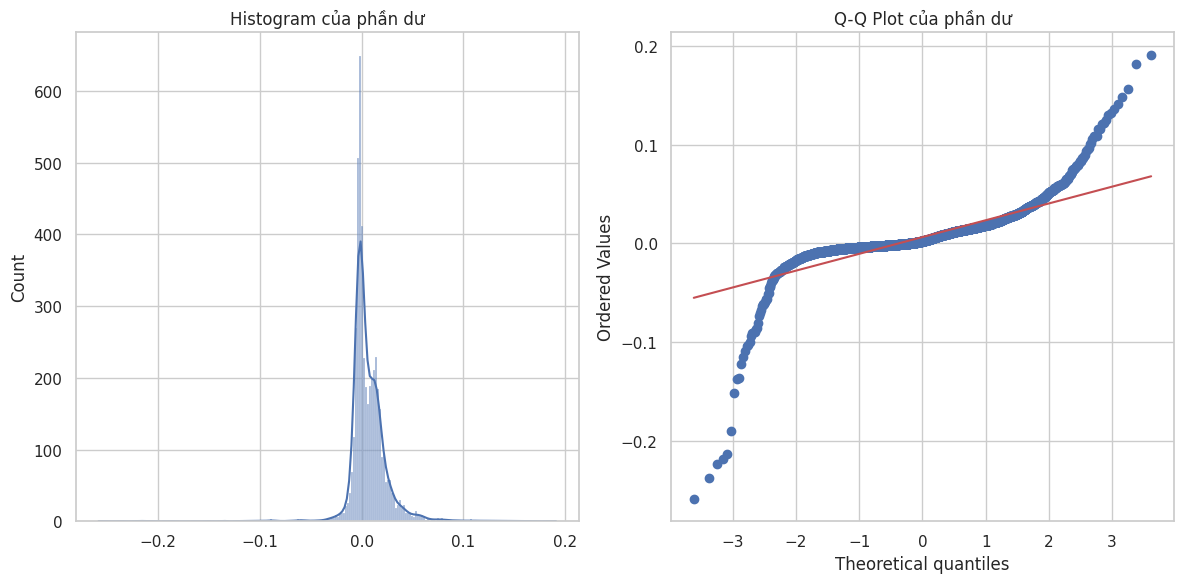

RMSE: 0.02114094995733361


<Figure size 1000x600 with 0 Axes>

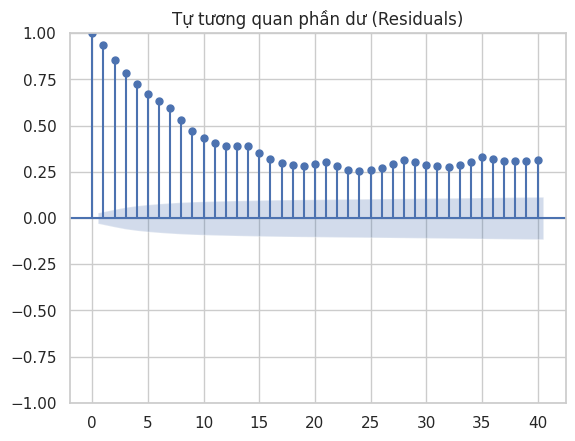

In [66]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Giả sử y_test_rescaled và y_pred_rescaled là các dữ liệu đã được rescale
# Tính phần dư
residuals = y_test_rescaled - y_pred_rescaled

# Làm phẳng residuals từ 2 chiều thành 1 chiều trước khi chuyển thành pandas Series
residuals_flat = residuals.flatten()

# Chuyển residuals thành pandas Series và loại bỏ NaN
residuals_series = pd.Series(residuals_flat).dropna()

# 1. Chẩn đoán phần dư: Vẽ histogram và Q-Q plot
plt.figure(figsize=(12, 6))

# Vẽ histogram của phần dư
plt.subplot(1, 2, 1)
sns.histplot(residuals_series, kde=True)
plt.title('Histogram của phần dư')

# Vẽ Q-Q plot để kiểm tra phân phối chuẩn
plt.subplot(1, 2, 2)
stats.probplot(residuals_series, dist="norm", plot=plt)
plt.title('Q-Q Plot của phần dư')

plt.tight_layout()
plt.show()

# 2. Tính RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'RMSE: {rmse}')

# 3. Kiểm tra phần dư có phải là chuỗi ngẫu nhiên (autocorrelation)
plt.figure(figsize=(10, 6))
plot_acf(residuals_series, lags=40)  # Vẽ đồ thị tự tương quan của phần dư
plt.title('Tự tương quan phần dư (Residuals)')
plt.show()


In [67]:
from scipy.stats import shapiro

# Kiểm tra phân phối chuẩn của phần dư với kiểm định Shapiro-Wilk
stat, p_value = shapiro(residuals_series)
print(f'Giá trị thống kê Shapiro-Wilk: {stat}')
print(f'P-value: {p_value}')

if p_value > 0.05:
    print("Phần dư có phân phối chuẩn (không bác bỏ H0)")
else:
    print("Phần dư không có phân phối chuẩn (bác bỏ H0)")


Giá trị thống kê Shapiro-Wilk: 0.7149082489808282
P-value: 6.249523210398884e-67
Phần dư không có phân phối chuẩn (bác bỏ H0)


In [68]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Kiểm định Ljung-Box để kiểm tra tự tương quan của phần dư
ljungbox_test_garch = acorr_ljungbox(residuals_series, lags=40)
print(ljungbox_test_garch)


         lb_stat  lb_pvalue
1    4064.970409        0.0
2    7478.727013        0.0
3   10364.192101        0.0
4   12803.209841        0.0
5   14899.550359        0.0
6   16761.200145        0.0
7   18427.454178        0.0
8   19738.478486        0.0
9   20775.331822        0.0
10  21648.592308        0.0
11  22417.432510        0.0
12  23123.929408        0.0
13  23826.133315        0.0
14  24528.906877        0.0
15  25102.777993        0.0
16  25574.550227        0.0
17  25989.469008        0.0
18  26371.235549        0.0
19  26747.008759        0.0
20  27141.460799        0.0
21  27565.273281        0.0
22  27935.219077        0.0
23  28256.719052        0.0
24  28564.203410        0.0
25  28879.496077        0.0
26  29220.915628        0.0
27  29620.041984        0.0
28  30084.399314        0.0
29  30516.495489        0.0
30  30904.186215        0.0
31  31272.771563        0.0
32  31637.008856        0.0
33  32018.292256        0.0
34  32456.856814        0.0
35  32966.112391    